In [2]:
# import torch

# device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
# print(f"Using {device} device")

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11535644126544307768
xla_global_id: -1
]


In [4]:
# import os
# os.environ["KERAS_BACKEND"] = "torch"
# import keras

# Step 1: Brief description of the problem and data

The Kaggle Challenge problem is to create an algorithm that identifies metastatic cancer in images. 

The data is a modified version of the PatchCamelyon dataset.

From the problem description we gather that this is a Binary Classification problem where the prediction parameter is: at least one pixel of tumor tissue is found in the center 32x32 px region of the image.

Kaggle presents the data as two main folders: test and train. 

They also provide a sample submission file as an example, and the train_lables.csv files. 

On the train folder we can find 220_025 .tif images with a shape of 96 x 96 x 3. 

For the test files, we have the same dimensions, but 56_458 image files.

# Step 2: Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

I will be loading the train data, visualizing some of the images and checking if some data needs to be cleaned. 

In [5]:
import os
import pandas as pd

whole_data_folder = 'histopathologic-cancer-detection'

train_data_path = os.path.join(whole_data_folder,'train')
# os.listdir(train_data_path)

In [6]:
train_labels = pd.read_csv(os.path.join(whole_data_folder,'train_labels.csv'))

In [7]:
train_labels


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0
...,...,...
220020,53e9aa9d46e720bf3c6a7528d1fca3ba6e2e49f6,0
220021,d4b854fe38b07fe2831ad73892b3cec877689576,1
220022,3d046cead1a2a5cbe00b2b4847cfb7ba7cf5fe75,0
220023,f129691c13433f66e1e0671ff1fe80944816f5a2,0


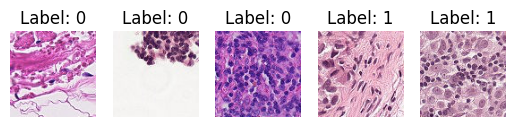

In [8]:
import matplotlib.pyplot as plt
from PIL import Image

def show_images(df, image_folder):

    samples = df.sample(5)

    for i, (image_id, label) in enumerate(zip(samples["id"], samples["label"])):
        img_path = os.path.join(image_folder, f"{image_id}.tif")
        img = Image.open(img_path)

        plt.subplot(1, 5, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Label: {label}")
    
    plt.show()

show_images(train_labels, train_data_path)

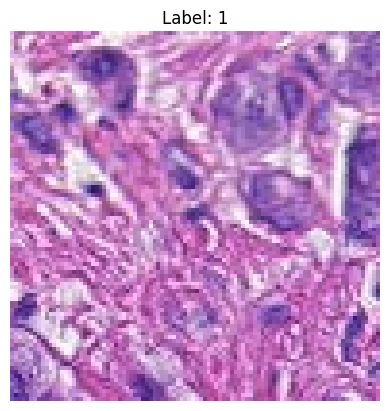

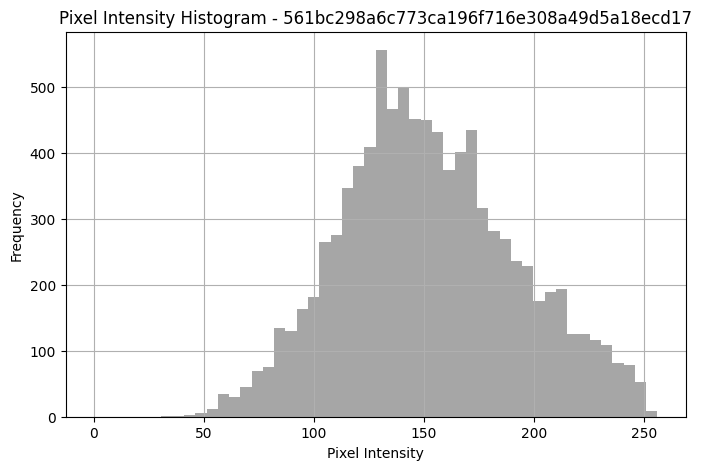

In [9]:
import numpy as np

def show_images(df, image_folder, n = 5):

    samples = df.sample(n)

    for i, (image_id, label) in enumerate(zip(samples["id"], samples["label"])):
        img_path = os.path.join(image_folder, f"{image_id}.tif")
        img = Image.open(img_path)

        plt.subplot(1, n, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Label: {label}")

        img_gray = img.convert("L")  # Convert to grayscale
        img_array = np.array(img_gray)

        # Plot histogram of pixel intensities
        plt.figure(figsize=(8, 5))
        plt.hist(img_array.ravel(), bins=50, range=(0, 256), color="gray", alpha=0.7)
        plt.xlabel("Pixel Intensity")
        plt.ylabel("Frequency")
        plt.title(f"Pixel Intensity Histogram - {image_id}")
        plt.grid(True)
        plt.show()
    
    plt.show()

show_images(train_labels, train_data_path, 1)

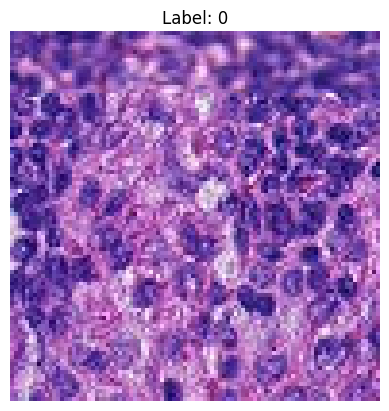

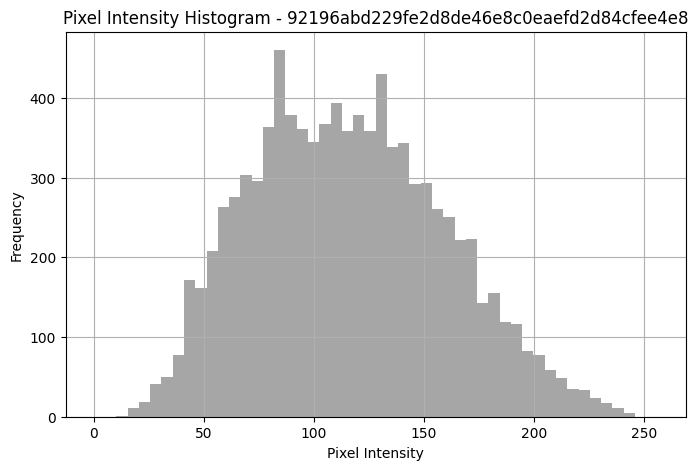

In [10]:
show_images(train_labels, train_data_path, 1)

At this stage we get a deeper understanding of how these images are distributed. We've also checked and all images are usable. 

# Step 3: DModel Architecture 

I will be testing multiple models and transfer learning for this step. 

I'll also prepare a keras.utils.image_dataset_from_directory directory using the dataframe I've generated previously.

In [11]:
# import os
# import shutil
# from tqdm import tqdm

# new_base_path = os.path.join(whole_data_folder, "train_split")

# for label in train_labels["label"].unique():
#     label_folder = os.path.join(new_base_path, str(label))
#     os.makedirs(label_folder, exist_ok=True)

# for _, row in tqdm(train_labels.iterrows(), total=len(train_labels)):
#     image_id = row["id"]
#     label = row["label"]
    
#     src = os.path.join(train_data_path, f"{image_id}.tif")
#     dst = os.path.join(new_base_path, str(label), f"{image_id}.tif")
    
#     # print(src,dst)
#     shutil.copy(src, dst)

# print("Images organized successfully!")


In [12]:
# from PIL import Image
# import os
# import shutil
# from tqdm import tqdm

# # Define new base path for organized dataset
# new_base_path = os.path.join(whole_data_folder, "train_split_png")

# # Create label subfolders
# for label in train_labels["label"].unique():
#     label_folder = os.path.join(new_base_path, str(label))
#     os.makedirs(label_folder, exist_ok=True)

# # Convert and copy each image
# for _, row in tqdm(train_labels.iterrows(), total=len(train_labels)):
#     image_id = row["id"]
#     label = row["label"]
    
#     tif_path = os.path.join(train_data_path, f"{image_id}.tif")
#     png_path = os.path.join(new_base_path, str(label), f"{image_id}.png")

#     try:
#         img = Image.open(tif_path)
#         img.save(png_path)  # Save as PNG
#     except Exception as e:
#         print(f"Error converting {image_id}: {e}")

In [13]:
import keras

new_base_path = os.path.join(whole_data_folder, "train_split_png")

train, test = keras.utils.image_dataset_from_directory(
    new_base_path,
    image_size=(96, 96),
    batch_size=32,
    label_mode='int',
    validation_split=0.3,
    seed=1337,
    subset="both"
)

# Optional: preview a batch
for images, labels in train.take(1):
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)

Found 220025 files belonging to 2 classes.
Using 154018 files for training.
Using 66007 files for validation.
Image batch shape: (32, 96, 96, 3)
Label batch shape: (32,)


In [14]:
train

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 96, 96, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

We visualize again with the converted images on the dataset.

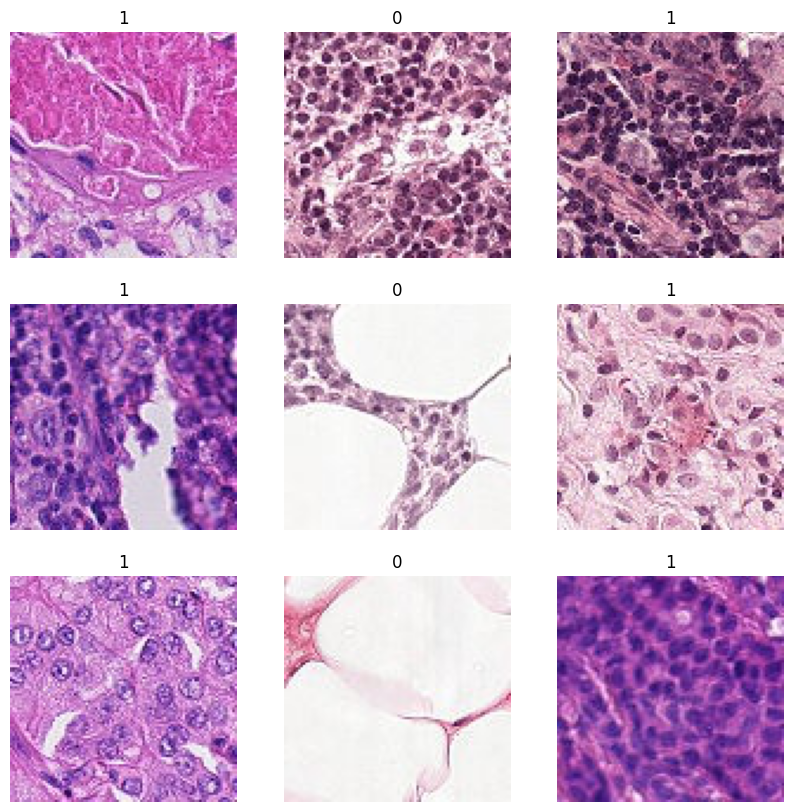

In [15]:
plt.figure(figsize=(10, 10))
for images, labels in train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [16]:
image_size = (96, 96, 3)

In [15]:
# from keras import layers

# def make_model(input_shape, num_classes):
#     inputs = keras.Input(shape=input_shape)

#     # Entry block
#     x = layers.Rescaling(1.0 / 255)(inputs)
#     x = layers.Conv2D(96, 3, strides=2, padding="same")(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Activation("relu")(x)

#     previous_block_activation = x  # Set aside residual

#     for size in [256, 512, 728]:
#         x = layers.Activation("relu")(x)
#         x = layers.SeparableConv2D(size, 3, padding="same")(x)
#         x = layers.BatchNormalization()(x)

#         x = layers.Activation("relu")(x)
#         x = layers.SeparableConv2D(size, 3, padding="same")(x)
#         x = layers.BatchNormalization()(x)

#         x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

#         # Project residual
#         residual = layers.Conv2D(size, 1, strides=2, padding="same")(
#             previous_block_activation
#         )
#         x = layers.add([x, residual])  # Add back residual
#         previous_block_activation = x  # Set aside next residual

#     x = layers.SeparableConv2D(1024, 3, padding="same")(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Activation("relu")(x)

#     x = layers.GlobalAveragePooling2D()(x)
#     if num_classes == 2:
#         units = 1
#     else:
#         units = num_classes

#     x = layers.Dropout(0.25)(x)
#     # We specify activation=None so as to return logits
#     outputs = layers.Dense(units, activation=None)(x)
#     return keras.Model(inputs, outputs)



In [33]:
from keras import layers

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(96, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [96*(i+1) for i in range(5)]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)
    # We specify activation=None so as to return logits
    outputs = layers.Dense(units, activation=None)(x)
    return keras.Model(inputs, outputs)



In [34]:
model = make_model(input_shape=image_size, num_classes=2)

In [38]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 96, 96, 3) │          0 │ input_layer_3[0]… │
│ (Rescaling)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 48, 48,    │      2,688 │ rescaling_3[0][0] │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 48, 48,    │        384 │ conv2d_10[0][0]   │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_20       │ (None, 48, 48,    │          0 │ batch_normalizat… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_21       │ (None, 48, 48,    │          0 │ activation_20[0]… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_17 │ (None, 48, 48,    │     10,176 │ activation_21[0]… │
│ (SeparableConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 48, 48,    │        384 │ separable_conv2d… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_22       │ (None, 48, 48,    │          0 │ batch_normalizat… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_18 │ (None, 48, 48,    │     10,176 │ activation_22[0]… │
│ (SeparableConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 48, 48,    │        384 │ separable_conv2d… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 24, 24,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 24, 24,    │      9,312 │ activation_20[0]… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_7 (Add)         │ (None, 24, 24,    │          0 │ max_pooling2d_7[… │
│                     │ 96)               │            │ conv2d_11[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_23       │ (None, 24, 24,    │          0 │ add_7[0][0]       │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_19 │ (None, 24, 24,    │     19,488 │ activation_23[0]… │
│ (SeparableConv2D)   │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 24, 24,    │        768 │ separable_conv2d

 Total params: 5,401,861 (20.61 MB)

 Trainable params: 1,797,953 (6.86 MB)

 Non-trainable params: 8,000 (31.25 KB)

 Optimizer params: 3,595,908 (13.72 MB)

In [36]:
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("Third_save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)
model.fit(
    train,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=test,
)

Epoch 1/25
4814/4814 ━━━━━━━━━━━━━━━━━━━━ 348s 72ms/step - acc: 0.8267 - loss: 0.3840 - val_acc: 0.8677 - val_loss: 0.3492
Epoch 2/25
4814/4814 ━━━━━━━━━━━━━━━━━━━━ 349s 73ms/step - acc: 0.9007 - loss: 0.2402 - val_acc: 0.7774 - val_loss: 0.8232
Epoch 3/25
4814/4814 ━━━━━━━━━━━━━━━━━━━━ 350s 73ms/step - acc: 0.9242 - loss: 0.1910 - val_acc: 0.8734 - val_loss: 0.3411
Epoch 4/25
4814/4814 ━━━━━━━━━━━━━━━━━━━━ 350s 73ms/step - acc: 0.9361 - loss: 0.1620 - val_acc: 0.7924 - val_loss: 0.7158
Epoch 5/25
4814/4814 ━━━━━━━━━━━━━━━━━━━━ 351s 73ms/step - acc: 0.9468 - loss: 0.1387 - val_acc: 0.9035 - val_loss: 0.2527
Epoch 6/25
4814/4814 ━━━━━━━━━━━━━━━━━━━━ 351s 73ms/step - acc: 0.9537 - loss: 0.1199 - val_acc: 0.9215 - val_loss: 0.2223
Epoch 7/25
4814/4814 ━━━━━━━━━━━━━━━━━━━━ 351s 73ms/step - acc: 0.9602 - loss: 0.1039 - val_acc: 0.9124 - val_loss: 0.2388
Epoch 8/25
4814/4814 ━━━━━━━━━━━━━━━━━━━━ 351s 73ms/step - acc: 0.9652 - loss: 0.0924 - val_acc: 0.8087 - val_loss: 0.8700
Epoch 9/25
4814/

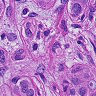

In [138]:
image = keras.utils.load_img(r"O:\Users\Vic\Documents\GitHub\CNNCancerDetection\histopathologic-cancer-detection\test\0aaacbf424f404bd7d78ba6a1e7d84798e75d8cc.tif",target_size=(96,96))
image

In [139]:
input_arr = keras.utils.img_to_array(image)
input_arr = np.expand_dims(input_arr, axis=0)
probability = keras.activations.sigmoid(model.predict(input_arr))
binary_output = (probability.cpu().numpy() > 0.5).astype(int)  
int(binary_output[0][0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


1